In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict

import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 3
device#: 0
device name: TITAN RTX

torch: 1.3.0
cuda:  10.1.243
cudnn: 7603
dtype: torch.float32


In [4]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [5]:
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'gabor_fwrf'

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 
input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/S%02d/dnn_fwrf_May-10-2020_1814/'
output_dir = root_dir+"output/S%02d/%s_%s/" % (subject,model_name,timestamp) 
video_dir  = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print ("Time Stamp: %s" % timestamp)

Time Stamp: Feb-28-2021_1634


# Load stimuli

In [6]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

In [11]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


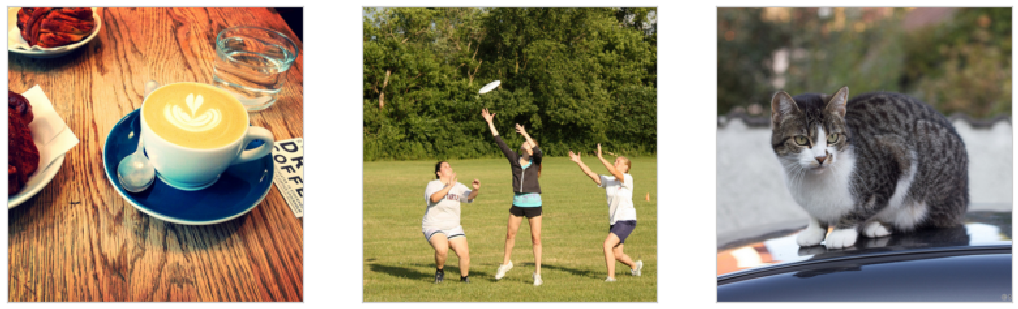

In [15]:
n = 6
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Load Voxels

In [16]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [18]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

#voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_inflated_1.0.nii"%subject)
voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%subject)
voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%subject)
voxel_kast_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))
general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))
ncsnr_full = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%subject)
###
brain_nii_shape = voxel_roi_full.shape
print (brain_nii_shape)
###
voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
###
voxel_mask  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
voxel_idx   = np.arange(len(voxel_mask))[voxel_mask]
voxel_roi   = voxel_joined_roi_full[voxel_mask]
voxel_ncsnr = ncsnr_full.flatten()[voxel_mask]
        
print ('full mask length = %d'%len(voxel_mask))
print ('selection length = %d'%np.sum(voxel_mask))
    
for roi_mask, roi_name in iterate_roi(group, voxel_roi, roi_map, group_name=group_names):
    print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

(81, 104, 83)
full mask length = 699192
selection length = 4627
1348 	: V1
1415 	: V2
1188 	: V3
676 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other


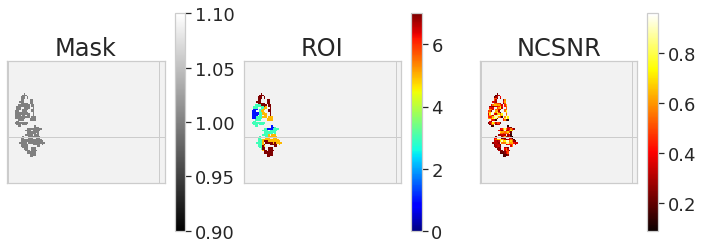

In [20]:
slice_idx = 35
plt.figure(figsize=(12, 4))
    
volume_brain_mask = view_data(brain_nii_shape, voxel_idx, np.ones_like(voxel_idx), save_to=output_dir+"subj%02d_mask"%subject)
volume_brain_roi  = view_data(brain_nii_shape, voxel_idx, voxel_roi, save_to=output_dir+"subj%02d_roi"%subject)
volume_ncsnr      = view_data(brain_nii_shape, voxel_idx, voxel_ncsnr, save_to=output_dir+"subj%02d_ncsnr"%subject) 
##
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.clim([0,7])
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,3)
plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
plt.title('NCSNR')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [33]:
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

from src.load_nsd import load_betas
voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=4, load_ext=".mat")
print (voxel_data.shape)

/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.579, <sigma> = 1.198
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.488, <sigma> = 1.116
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.793, <sigma> = 1.256
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 1.369, <sigma> = 1.060
(3000, 4627)


## Training/validation data split

In [34]:
from src.load_nsd import image_uncolorize_fn, data_split

data_size, nv = voxel_data.shape 
trn_stim_data, trn_voxel_data,\
val_stim_single_trial_data, val_voxel_single_trial_data,\
val_stim_multi_trial_data, val_voxel_multi_trial_data = \
    data_split(image_uncolorize_fn(image_data), voxel_data, ordering, imagewise=False)

Total number of voxels = 4627


In [35]:
del voxel_data

In [41]:
trn_stim_mean = np.mean(trn_stim_data, axis=(0,2,3), keepdims=True)
print (trn_stim_mean)

[[[[0.45665962]]]]


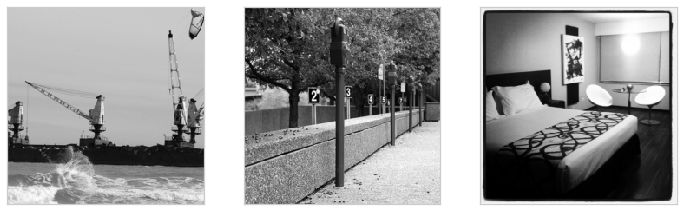

In [40]:
n = 6
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(trn_stim_data[n+i,0], cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Create model
By arbitrary convention, all variables, ojects or functions that return either of those on the device will begin with an underscore.

In [29]:
from src.torch_fwrf import get_value, set_value
from src.gabor_feature_extractor import Gaborizer
from src.rf_grid import linspace, logspace

In [26]:
class add_nonlinearity(L.Module):
    def __init__(self, _fmaps_fn, _nonlinearity):
        super(add_nonlinearity, self).__init__()
        self.fmaps_fn = _fmaps_fn
        self.nl_fn = _nonlinearity
    def forward(self, _x):
        return [self.nl_fn(_fm) for _fm in self.fmaps_fn(_x)]

In [27]:
n_ori = 6
cyc_per_stim = logspace(12)(3., 72.) # 6-92
_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=4.13, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

torch.Size([6, 1, 12, 12])
torch.Size([6, 1, 12, 12])


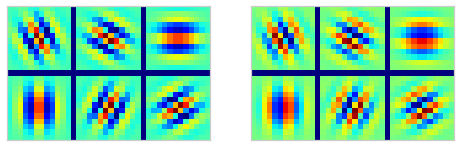

In [30]:
for _p in _fmaps_fn.parameters():
    print (_p.size())
##
plt.figure(figsize=(8, 4))
for k,_p in enumerate(_fmaps_fn.parameters()):
    plt.subplot(1,2,k+1)
    plt.imshow(pnu.mosaic_vis(get_value(_p)[:,0], pad=1), interpolation='None', cmap='jet')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

In [43]:
_x = torch.tensor(trn_stim_data[:100]).to(device) # the input variable.
_fmaps = _gaborizer(_x)

for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 6, 13, 13])
torch.Size([100, 6, 18, 18])
torch.Size([100, 6, 23, 23])
torch.Size([100, 6, 30, 30])
torch.Size([100, 6, 40, 40])
torch.Size([100, 6, 54, 54])
torch.Size([100, 6, 71, 71])
torch.Size([100, 6, 95, 95])
torch.Size([100, 6, 126, 126])
torch.Size([100, 6, 168, 168])
torch.Size([100, 6, 224, 224])
torch.Size([100, 6, 298, 298])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


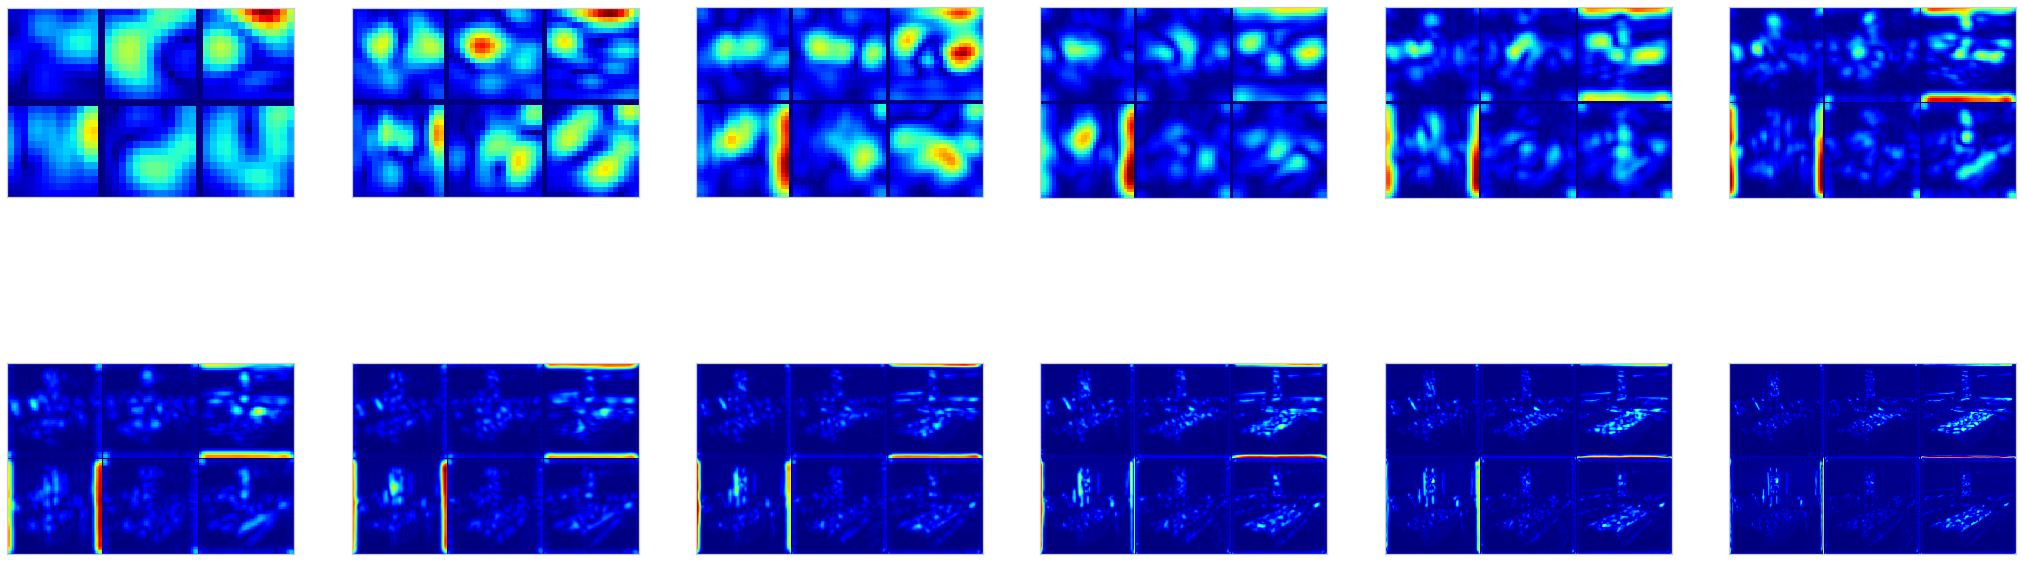

In [44]:
plt.figure(figsize=(36,12))
for k,_fm in enumerate(_fmaps[:12]):
    plt.subplot(2,6,k+1)
    plt.imshow(pnu.mosaic_vis(get_value(_fm)[8], pad=1), interpolation='None', cmap='jet')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

In [46]:
# this is just to get the tuning_masks
from src.torch_feature_space import filter_dnn_feature_maps
# I used image_data because the repeats are not relevant
_, lmask, fmask, tuning_masks = filter_dnn_feature_maps(trn_stim_data, _fmaps_fn, batch_size=100, fmap_max=512)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
28it [00:10,  2.77it/s]

layer: 0, shape=(100, 6, 13, 13)
layer: 1, shape=(100, 6, 18, 18)
layer: 2, shape=(100, 6, 23, 23)
layer: 3, shape=(100, 6, 30, 30)
layer: 4, shape=(100, 6, 40, 40)
layer: 5, shape=(100, 6, 54, 54)
layer: 6, shape=(100, 6, 71, 71)
layer: 7, shape=(100, 6, 95, 95)
layer: 8, shape=(100, 6, 126, 126)
layer: 9, shape=(100, 6, 168, 168)
layer: 10, shape=(100, 6, 224, 224)
layer: 11, shape=(100, 6, 298, 298)

fmaps: 0, shape=(100, 6, 298, 298)
fmaps: 1, shape=(100, 6, 224, 224)
fmaps: 2, shape=(100, 6, 168, 168)
fmaps: 3, shape=(100, 6, 126, 126)
fmaps: 4, shape=(100, 6, 95, 95)
fmaps: 5, shape=(100, 6, 71, 71)
fmaps: 6, shape=(100, 6, 54, 54)
fmaps: 7, shape=(100, 6, 40, 40)
fmaps: 8, shape=(100, 6, 30, 30)
fmaps: 9, shape=(100, 6, 23, 23)
fmaps: 10, shape=(100, 6, 18, 18)
fmaps: 11, shape=(100, 6, 13, 13)


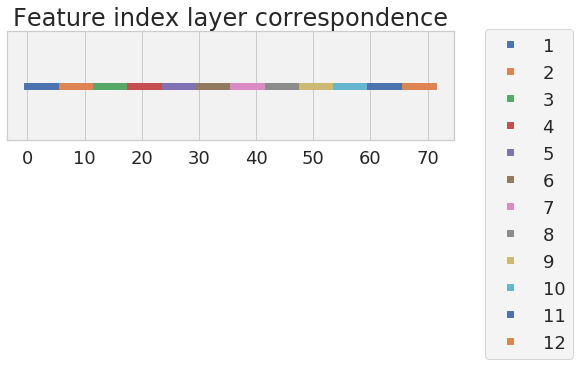

In [47]:
plt.figure(figsize=(8, 2))
for k,tm in enumerate(tuning_masks):
    _=plt.plot(tm, marker='s', linestyle='None', label=k+1)
_=plt.title('Feature index layer correspondence')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.1))

# fwRF training procedure
The model is
$$ r(t) = b + W * [f(\int_\mathrm{space}\phi(x,y,t) * g(x,y) dxdy) - m] / \sigma $$
where
$g(x,y)$ is a gaussian pooling field shared by all feature maps

$\phi(x,y,t)$ are the feature maps corresponding to stimuli $t$

$W, b$ are the feature weights and bias of the linearized model for each voxels

$f(\cdot)$ is an optional nonlinearity

$m,\sigma$ are normalization coefficient to facilitate regularization

In [51]:
from src.rf_grid    import linspace, logspace, model_space, model_space_pyramid
from src.torch_fwrf import learn_params_ridge_regression, get_predictions

aperture = np.float32(1)
smin, smax = np.float32(0.04), np.float32(0.4)
ns = 8

models = model_space_pyramid(logspace(ns)(smin, smax), min_spacing=1.4, aperture=1.1*aperture)
print ('candidate count = ', len(models))

sample_batch_size = 200
voxel_batch_size = 500
holdout_size = 500
lambdas = np.logspace(0.,5.,9, dtype=np.float32)

candidate count =  875


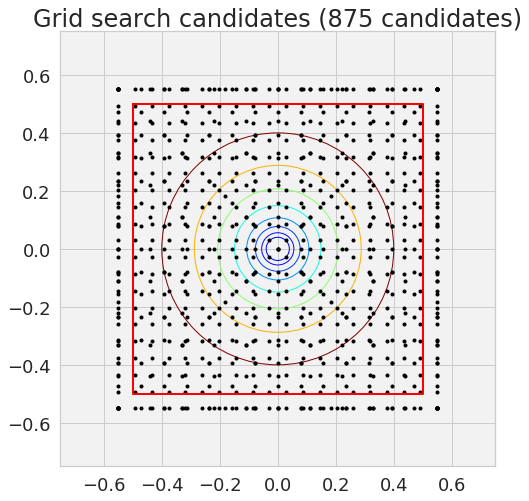

In [49]:
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
import matplotlib.cm as cmx

lx, vx = aperture, aperture * 1.5
cNorm  = colors.Normalize(vmin=.0, vmax=.4)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('jet') )

fig=plt.figure(figsize=(8, 8))
plt.title('Grid search candidates (%d candidates)' % len(models))
plt.plot(models[:,0], models[:,1], '.k', linestyle='None')
ax = plt.gca()
for s in np.unique(models[:,2]):
    ax.add_artist(Ellipse(xy=(0,0), width=2*s, height=2*s, angle=0,
        color=scalarMap.to_rgba(s), lw=1, fill=False))
_=ax.set_xlim(-vx/2, vx/2)
_=ax.set_ylim(-vx/2, vx/2)
_=ax.set_aspect('equal')
plt.plot([-lx/2,lx/2,lx/2,-lx/2,-lx/2], [lx/2,lx/2,-lx/2,-lx/2, lx/2], 'r', lw=2)

In [ ]:
filename = output_dir + "rf_grid%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

In [52]:
from src.torch_fwrf import  learn_params_ridge_regression, get_predictions, Torch_fwRF_voxel_block

best_losses, best_lambdas, best_params = learn_params_ridge_regression(
    trn_stim_data, trn_voxel_data, _fmaps_fn, models, lambdas, \
    aperture=aperture, _nonlinearity=None, zscore=True, sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=False, add_bias=True)

trn_size = 2217 (81.6%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([200, 6, 13, 13])
torch.Size([200, 6, 18, 18])
torch.Size([200, 6, 23, 23])
torch.Size([200, 6, 30, 30])
torch.Size([200, 6, 40, 40])
torch.Size([200, 6, 54, 54])
torch.Size([200, 6, 71, 71])
torch.Size([200, 6, 95, 95])
torch.Size([200, 6, 126, 126])
torch.Size([200, 6, 168, 168])
torch.Size([200, 6, 224, 224])
torch.Size([200, 6, 298, 298])
---------------------------------------

model  874 of 875 , voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 1755.009255s
total throughput = 0.379297s/voxel
voxel throughput = 0.010824s/voxel
setup throughput = 1.948486s/model


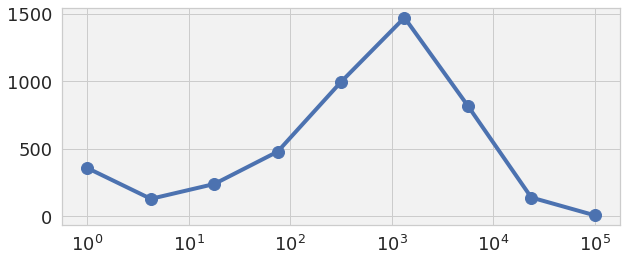

In [53]:
plt.figure(figsize=(10,4))
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')

In [54]:
print ([p.shape if p is not None else None for p in best_params])

[(4627, 3), (4627, 72), (4627,), (4627, 72), (4627, 72)]


In [57]:
param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]

_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=None, input_shape=trn_stim_data.shape, aperture=1.0)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [58]:
# image are done redundantly for single trial data--but that's simpler
val_voxel_pred = get_predictions(val_stim_single_trial_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)

samples [  200:282  ] of 283, voxels [     0:499   ] of 4627

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


samples [  200:282  ] of 283, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.856630s
sample throughput = 0.225642s/sample
voxel throughput = 0.013801s/voxel


In [60]:
#val_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
val_cc  = np.zeros(shape=(nv), dtype=fpX)
for v in tqdm(range(nv)):    
    val_cc[v] = np.corrcoef(val_voxel_single_trial_data[:,v], val_voxel_pred[:,v])[0,1]  
val_cc = np.nan_to_num(val_cc)

100%|██████████| 4627/4627 [00:00<00:00, 9542.63it/s]


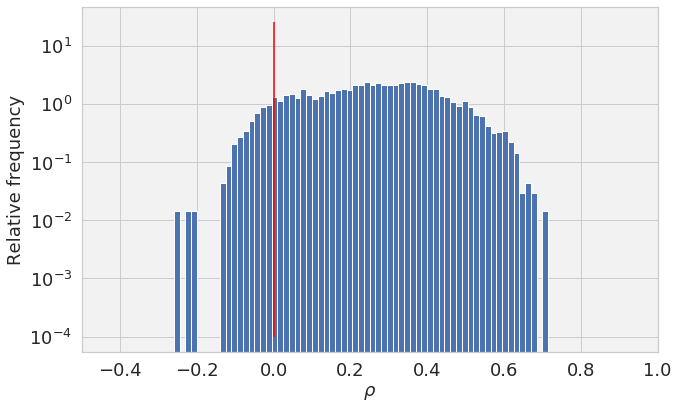

In [61]:
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.5, 1.0])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

In [62]:
best_models = best_params[0]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

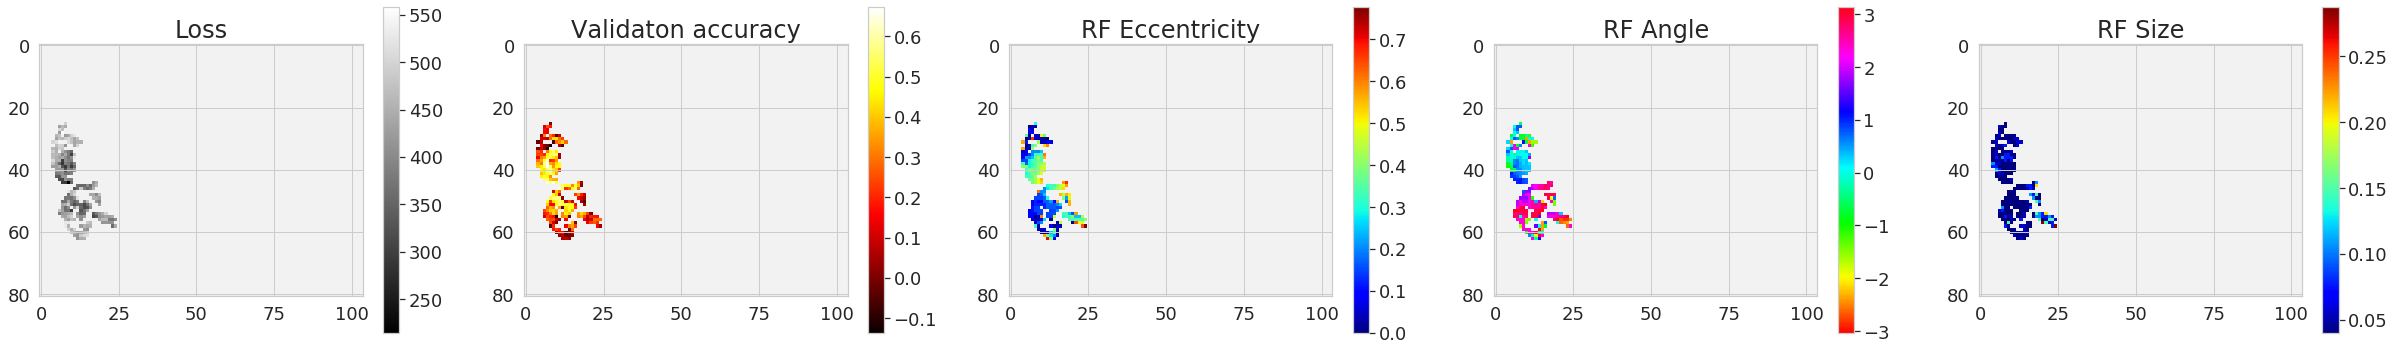

In [63]:
volume_loss = view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = view_data(brain_nii_shape, voxel_idx, val_cc, save_to=output_dir+"val_cc")
volume_ecc  = view_data(brain_nii_shape, voxel_idx, best_ecc, save_to=output_dir+"rf_ecc")
volume_ang  = view_data(brain_nii_shape, voxel_idx, best_ang, save_to=output_dir+"rf_ang")
volume_size = view_data(brain_nii_shape, voxel_idx, best_size, save_to=output_dir+"rf_size")

slice_idx = 40
fig = plt.figure(figsize=(42,6))
plt.subplot(1,5,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='gray', interpolation='None')
plt.colorbar()
plt.subplot(1,5,2)
plt.title('Validaton accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='hot', interpolation='None')
plt.colorbar()
plt.subplot(1,5,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(1,5,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(1,5,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

# Save results to disk

In [66]:
torch.save({
    'lmask': lmask,
    'fmask': fmask,
    'tuning_masks': tuning_masks,
    'cyc_per_stim': cyc_per_stim,
    'aperture': aperture,
    'voxel_mask': voxel_mask,
    'brain_nii_shape': np.array(brain_nii_shape),
    'image_order': ordering,
    'voxel_index': voxel_idx,
    'voxel_roi': voxel_roi,
    'params': best_params,
    'lambdas': lambdas, 
    'best_lambdas': best_lambdas,
    'val_cc': val_cc,
    }, output_dir+'model_params')

In [67]:
## Previous version

#model_params = {
#    'lmask': lmask,
#    'fmask': fmask,
#    'tuning_masks': tuning_masks,
#    'cyc_per_stim': cyc_per_stim,
#    'aperture': aperture,
#    'voxel_mask': voxel_mask,
#    'brain_nii_shape': np.array(brain_nii_shape),
#    'image_order': ordering,
#    'voxel_index': voxel_idx,
#    'voxel_roi': voxel_roi,
#    'params': best_params,
#    'lambdas': lambdas, 
#    'best_lambdas': best_lambdas,
#    'val_cc': val_cc,
#    }

#print (timestamp)
#save_stuff(output_dir + "model_params", flatten_dict(model_params))

# Spatial frequency tuning

In [69]:
sample_batch_size = 200 # 1000

partition_val_cc   = np.ndarray(shape=(len(tuning_masks),)+(nv,), dtype=fpX)    
for l,rl in enumerate(tuning_masks):
    partition_params = [np.copy(p) for p in best_params]
    partition_params[1][:,:]   = 0
    partition_params[1][:, rl] = best_params[1][:, rl]
    ###
    val_voxel_pred = get_predictions(val_stim_multi_trial_data, _fmaps_fn, _fwrf_fn, partition_params, sample_batch_size=sample_batch_size)
    #val_voxel_pred = voxel_pred[ordering[shared_mask]]
    for v in tqdm(range(nv)):    
        partition_val_cc[l,v] = np.corrcoef(val_voxel_pred[:,v], val_voxel_multi_trial_data[:,v])[0,1]

samples [    0:195  ] of 196, voxels [     0:499   ] of 4627

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.714045s
sample throughput = 0.325072s/sample
voxel throughput = 0.013770s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10427.29it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.736902s
sample throughput = 0.325188s/sample
voxel throughput = 0.013775s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10351.83it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.590299s
sample throughput = 0.324440s/sample
voxel throughput = 0.013743s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10288.45it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.500477s
sample throughput = 0.323982s/sample
voxel throughput = 0.013724s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10407.47it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.565070s
sample throughput = 0.324312s/sample
voxel throughput = 0.013738s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10382.04it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.560687s
sample throughput = 0.324289s/sample
voxel throughput = 0.013737s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10321.56it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.566076s
sample throughput = 0.324317s/sample
voxel throughput = 0.013738s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10473.58it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.557678s
sample throughput = 0.324274s/sample
voxel throughput = 0.013736s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10385.31it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.555499s
sample throughput = 0.324263s/sample
voxel throughput = 0.013736s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10458.38it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.088939s
sample throughput = 0.321882s/sample
voxel throughput = 0.013635s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10451.54it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 62.612261s
sample throughput = 0.319450s/sample
voxel throughput = 0.013532s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10404.65it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 62.542838s
sample throughput = 0.319096s/sample
voxel throughput = 0.013517s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10473.90it/s]


In [70]:
partition_variance = np.square(np.nan_to_num(partition_val_cc))
var_min = np.min(partition_variance, axis=0, keepdims=True)
var_max = np.max(partition_variance, axis=0, keepdims=True)
tuning_scores = np.nan_to_num(np.sort((partition_variance - var_min) / (var_max - var_min), axis=0))
###
tuning = np.nan_to_num(partition_variance / np.sum(partition_variance, axis=0, keepdims=True))
tuning_argmax = np.argmax(partition_variance, axis=0)
tuning_spread = np.zeros_like(val_cc)
for v in tqdm(range(nv)):  
    tuning_spread[v] = np.interp(0.5, tuning_scores[:,v], np.linspace(0.,1.,len(tuning_scores),endpoint=True)[::-1])

100%|██████████| 4627/4627 [00:00<00:00, 26537.37it/s]


0.71191895
argmax = 7 spread = 0.486391


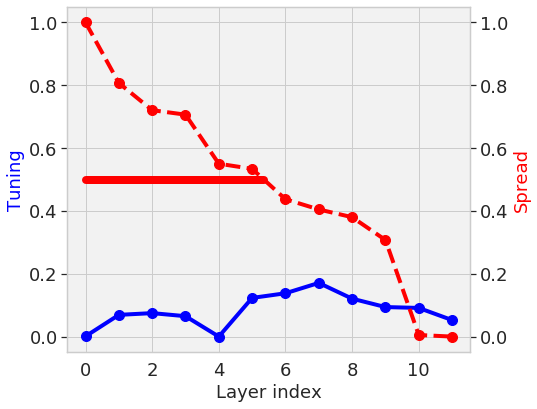

In [71]:
vidx = np.argsort(np.nan_to_num(val_cc))[-1]
print (val_cc[vidx])
print ('argmax = %d' % tuning_argmax[vidx], 'spread = %f' % tuning_spread[vidx])
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.85, top=.95, wspace=0., hspace=0.)
ax1=plt.gca()
ax2=ax1.twinx()
ax1.plot(tuning[:,vidx], marker='o', ms=10, color='b', lw=4)
ax1.set_ylim([-.05, 1.05])
ax1.set_xlabel('Layer index')
ax1.set_ylabel('Tuning', color='b')
ax2.plot(tuning_scores[::-1,vidx], marker='o', lw=4, linestyle='--', ms=10, color='r')
ax2.plot([0, (len(tuning)-1)*(tuning_spread[vidx])], [.5, .5], color='r', lw=8)
ax2.set_ylabel('Spread', color='r')
ax2.set_ylim([-.05,1.05])
ax2.grid(False)

In [72]:
filename = output_dir + "tuning_and_spread_example_%s%s"  % (vidx, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

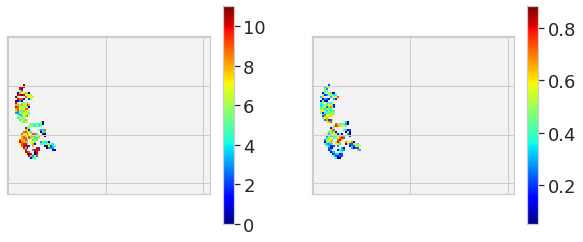

In [73]:
volume_brain_tuning  = view_data(brain_nii_shape, voxel_idx, tuning_argmax, save_to=output_dir+"layer_tuning")
volume_brain_spread  = view_data(brain_nii_shape, voxel_idx, tuning_spread, save_to=output_dir+"layer_spread")

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(volume_brain_tuning[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,2,2)
plt.imshow(volume_brain_spread[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [74]:
torch.save({
    'voxel_mask': voxel_mask,
    'brain_nii_shape': np.array(brain_nii_shape),
    'voxel_index': voxel_idx,
    'voxel_roi': voxel_roi, 
    'val_cc': val_cc,
    'cyc_per_stim': cyc_per_stim,
    'part_val_cc': partition_val_cc
    }, output_dir + 'model_freq_tuning')

# Orientation tuning

In [75]:
ori_tuning_masks = [np.zeros_like(tuning_masks[0]) for i in range(n_ori)]
for k,m in enumerate(ori_tuning_masks):
    m[range(k,len(m),n_ori)] = True
#print (ori_tuning_masks)

In [78]:
sample_batch_size = 200 # 1000

partition_val_cc   = np.ndarray(shape=(len(ori_tuning_masks),)+(nv,), dtype=fpX)    
for l,rl in enumerate(ori_tuning_masks):
    partition_params = [np.copy(p) for p in best_params]
    partition_params[1][:,:]   = 0
    partition_params[1][:, rl] = best_params[1][:, rl]
    ###
    val_voxel_pred = get_predictions(val_stim_multi_trial_data, _fmaps_fn, _fwrf_fn, partition_params, sample_batch_size=sample_batch_size)
    #val_voxel_pred = voxel_pred[ordering[shared_mask]]
    for v in tqdm(range(nv)):    
        partition_val_cc[l,v] = np.corrcoef(val_voxel_pred[:,v], val_voxel_multi_trial_data[:,v])[0,1]

samples [    0:195  ] of 196, voxels [     0:499   ] of 4627

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 62.699080s
sample throughput = 0.319893s/sample
voxel throughput = 0.013551s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10427.76it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 62.775640s
sample throughput = 0.320284s/sample
voxel throughput = 0.013567s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10452.32it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.155737s
sample throughput = 0.322223s/sample
voxel throughput = 0.013649s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10532.20it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.458624s
sample throughput = 0.323768s/sample
voxel throughput = 0.013715s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10409.17it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.316417s
sample throughput = 0.323043s/sample
voxel throughput = 0.013684s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10517.77it/s]


samples [    0:195  ] of 196, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.163918s
sample throughput = 0.322265s/sample
voxel throughput = 0.013651s/voxel


100%|██████████| 4627/4627 [00:00<00:00, 10545.46it/s]


In [79]:
partition_variance = np.square(np.nan_to_num(partition_val_cc))
var_min = np.min(partition_variance, axis=0, keepdims=True)
var_max = np.max(partition_variance, axis=0, keepdims=True)
tuning_scores = np.nan_to_num(np.sort((partition_variance - var_min) / (var_max - var_min), axis=0))
###
tuning = np.nan_to_num(partition_variance / np.sum(partition_variance, axis=0, keepdims=True))
tuning_argmax = np.argmax(partition_variance, axis=0)
tuning_spread = np.zeros_like(val_cc)
for v in tqdm(range(nv)):  
    tuning_spread[v] = np.interp(0.5, tuning_scores[:,v], np.linspace(0.,1.,len(tuning_scores),endpoint=True)[::-1])

100%|██████████| 4627/4627 [00:00<00:00, 26221.45it/s]


0.5651384
argmax = 0 spread = 0.656229


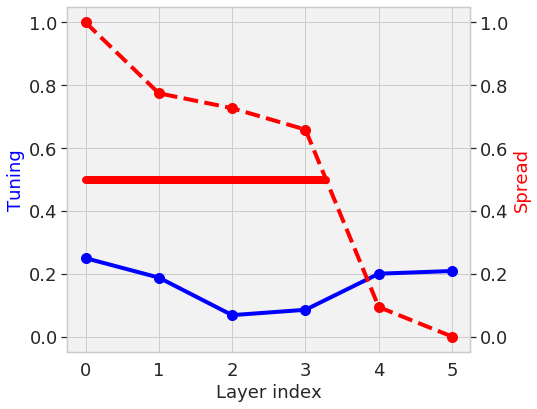

In [86]:
vidx = np.argsort(np.nan_to_num(val_cc))[-102]
print (val_cc[vidx])
print ('argmax = %d' % tuning_argmax[vidx], 'spread = %f' % tuning_spread[vidx])
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.85, top=.95, wspace=0., hspace=0.)
ax1=plt.gca()
ax2=ax1.twinx()
ax1.plot(np.arange(0, len(ori_tuning_masks)), tuning[:,vidx], marker='o', ms=10, color='b', lw=4)
ax1.set_ylim([-.05, 1.05])
ax1.set_xlabel('Layer index')
ax1.set_ylabel('Tuning', color='b')
ax2.plot(np.arange(0, len(ori_tuning_masks)), tuning_scores[:,vidx][::-1], marker='o', lw=4, linestyle='--', ms=10, color='r')
ax2.plot([0, (len(ori_tuning_masks)-1)*(tuning_spread[vidx])], [.5, .5], color='r', lw=8)
ax2.set_ylabel('Spread', color='r')
ax2.set_ylim([-.05,1.05])
ax2.grid(False)

In [87]:
filename = output_dir + "tuning_and_spread_example_ori_%s%s"  % (vidx, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

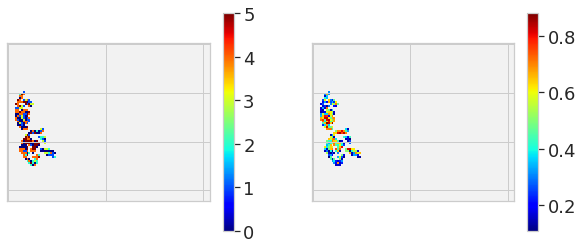

In [82]:
volume_brain_tuning  = view_data(brain_nii_shape, voxel_idx, tuning_argmax, save_to=output_dir+"layer_orientation_tuning")
volume_brain_spread  = view_data(brain_nii_shape, voxel_idx, tuning_spread, save_to=output_dir+"layer_orientation_spread")

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(volume_brain_tuning[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,2,2)
plt.imshow(volume_brain_spread[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [83]:
torch.save({
    'voxel_mask': voxel_mask,
    'brain_nii_shape': np.array(brain_nii_shape),
    'voxel_index': voxel_idx,
    'voxel_roi': voxel_roi, 
    'val_cc': val_cc,
    'part_val_cc': partition_val_cc
    }, output_dir + 'model_orientation_tuning')